In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import json

from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import pyswarms as ps

from dotenv import load_dotenv, find_dotenv
from pathlib import Path

from src.data.rgbd import load_rgbd
from src.data.pcd import load_pcd
from src.features.cropping import mask_selection_volume, box_mask_from_rgbd
from src.features.voxels import voxel2np, dig_box
from src.models.pso import eval_position, reward, _PointCloudTransmissionFormat, dig_and_predict

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
project_dir = Path(dotenv_path).parent

# load up the entries as environment variables
load_dotenv(dotenv_path)

o3d.visualization.webrtc_server.enable_webrtc()

[Open3D INFO] WebRTC GUI backend enabled.


RuntimeError: [1;31m[Open3D Error] (void open3d::visualization::gui::Application::SetWindowSystem(std::shared_ptr<open3d::visualization::gui::WindowSystem>)) /home/ctc_das/Desktop/Open3D/cpp/open3d/visualization/gui/Application.cpp:355: Cannot set WindowSystem. It is already set.
[0;m

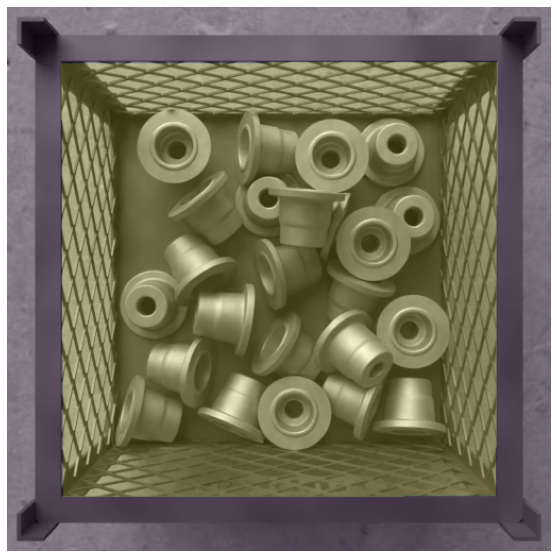

In [5]:
raw_data_dir = project_dir/'data/raw/render_results_imov_cam_mist_simple'

img_fpath = np.random.choice(list(raw_data_dir.glob('*/*.exr')))

rgbd = load_rgbd(img_fpath)

box_mask = box_mask_from_rgbd(rgbd)

plt.imshow(rgbd.color, cmap='gray')
plt.imshow(box_mask, alpha=0.2)
plt.gcf().set_size_inches(10,10)
plt.gca().set_axis_off()
plt.show()

In [6]:
vol = mask_selection_volume(rgbd, box_mask)

pcd = load_pcd(rgbd)

box = vol.crop_point_cloud(pcd)

part_fpath = project_dir/'data/raw/part.stl'

part_mesh = o3d.io.read_triangle_mesh(str(part_fpath), enable_post_processing=True)

part_mesh.paint_uniform_color([1., 0., 0.,])

part = part_mesh.sample_points_uniformly(number_of_points=10000)

part_points = np.array(part.points) / 1000  # mm to meter conversion
part_points = part_points + np.array([0,0,0.3])
part_points = o3d.utility.Vector3dVector(part_points)
part.points = part_points

box, part

(PointCloud with 81563 points., PointCloud with 10000 points.)

In [54]:
voxel_size = 0.005

box_voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(box, voxel_size)

# get grid shape and position
grid_pos = box_voxel.get_min_bound()
grid_pos[-1] = 0.1288  # floor

grid_shape = (box_voxel.get_max_bound() - grid_pos) / box_voxel.voxel_size
grid_shape = (grid_shape + 0.5).astype(int)

box_grid = voxel2np(box_voxel, grid_pos, grid_shape)


min_bound = np.array([-0.5, -0.5, -0.5, -np.pi, -np.pi, -np.pi])
bounds = (min_bound, -min_bound)

optimizer = ps.single.LocalBestPSO(
    n_particles=18,
    dimensions=6,
    bounds=bounds,
    options={'c1': 0.5, 'c2': 0.2, 'w':0.9, 'k': 2, 'p': 2},
)

optimizer

In [6]:
%matplotlib widget

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(box_grid, facecolors='gray')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
def objective_f(xs, box_grid, part, voxel_size, grid_pos, grid_shape):
    if xs.size > 0:
        return np.apply_along_axis(eval_position, -1, xs, box_grid=box_grid, part=part, voxel_size=voxel_size, grid_pos=grid_pos, grid_shape=grid_shape)
    else:
        return np.apply_along_axis(eval_position, -1, np.array([0.,0.,0.,0.,0.,0.]), box_grid=box_grid, part=part, voxel_size=voxel_size, grid_pos=grid_pos, grid_shape=grid_shape)

%time cost, pos = optimizer.optimize(objective_f, iters=250, n_processes=6, box_grid=box_grid, part=_PointCloudTransmissionFormat(part), voxel_size=voxel_size, grid_pos=grid_pos, grid_shape=grid_shape)

2022-03-02 10:40:35,981 - pyswarms.single.local_best - INFO - Optimize for 250 iters with {'c1': 0.5, 'c2': 0.0, 'w': 0.9, 'k': 2, 'p': 2}
pyswarms.single.local_best: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|250/250, best_cost=-3992.0
2022-03-02 10:40:46,542 - pyswarms.single.local_best - INFO - Optimization finished | best cost: -3992.0, best pos: [-0.03297941  0.00159879  0.13323385  0.10131334  0.69351407  0.0721172 ]


CPU times: user 1.99 s, sys: 468 ms, total: 2.45 s
Wall time: 10.6 s


In [8]:
# get part at optimal position
tx, ty, tz, rx, ry, rz = pos

part_ = o3d.geometry.PointCloud(part)

part_.translate(np.array([tx, ty, tz]))

part_.rotate(
    o3d.geometry.get_rotation_matrix_from_xyz(np.array([rx, ry, rz]))
)

part_voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(part_, voxel_size)
part_grid = voxel2np(part_voxel, grid_pos, grid_shape, mode='floating')

# find out how much of the part is immersed at the box content
immersion_ratio = (part_grid & box_grid).sum() / part_grid.sum()
immersion_ratio

0.9368037703513282

# Digging loop

In [55]:
n = 0  # number of parts

curr_box_grid = box_grid.copy()

In [57]:
box_grid.sum()

599364

2022-03-02 20:31:13,227 - pyswarms.single.local_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.9, 'k': 2, 'p': 2}
pyswarms.single.local_best: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|500/500, best_cost=-31456.0
2022-03-02 20:32:46,672 - pyswarms.single.local_best - INFO - Optimization finished | best cost: -31456.0, best pos: [ 0.05637761  0.1781118   0.16496374 -0.99111835  1.42369264  0.24915782]
2022-03-02 20:32:46,800 - pyswarms.single.local_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.9, 'k': 2, 'p': 2}
pyswarms.single.local_best: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|500/500, best_cost=-30769.0
2022-03-02 20:34:24,504 - pyswarms.single.local_best - INFO - Optimizat

no more parts!
parts digged:  26


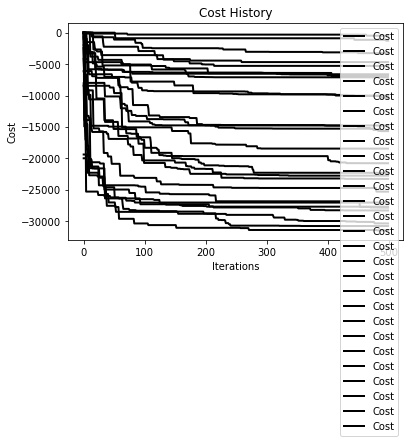

CPU times: user 2min 7s, sys: 42 s, total: 2min 49s
Wall time: 42min 19s


In [58]:
%%time

%matplotlib inline

def objective_f(xs, box_grid, part, voxel_size, grid_pos, grid_shape):
    if xs.size > 0:
        return np.apply_along_axis(eval_position, -1, xs, box_grid=box_grid, part=part, voxel_size=voxel_size, grid_pos=grid_pos, grid_shape=grid_shape)
    else:
        return np.apply_along_axis(eval_position, -1, np.array([0.,0.,0.,0.,0.,0.]), box_grid=box_grid, part=part, voxel_size=voxel_size, grid_pos=grid_pos, grid_shape=grid_shape)

ax = plt.subplot()
while True:
    optimizer = ps.single.LocalBestPSO(
        n_particles=18,
        dimensions=6,
        bounds=bounds,
        options={'c1': 0.5, 'c2': 0.2, 'w':0.9, 'k': 2, 'p': 2},
    )

    cost, pos = optimizer.optimize(objective_f, iters=500, n_processes=6, box_grid=curr_box_grid, part=_PointCloudTransmissionFormat(part), voxel_size=voxel_size, grid_pos=grid_pos, grid_shape=grid_shape)

    ax = plot_cost_history(cost_history=optimizer.cost_history, ax=ax, label=n+1)
    
    # get part at optimal position
    tx, ty, tz, rx, ry, rz = pos

    part_ = o3d.geometry.PointCloud(part)

    part_.translate(np.array([tx, ty, tz]))

    part_.rotate(
        o3d.geometry.get_rotation_matrix_from_xyz(np.array([rx, ry, rz]))
    )

    part_voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(part_, voxel_size)
    part_grid = voxel2np(part_voxel, grid_pos, grid_shape, mode='floating')

    # find out how much of the part is immersed at the box content
    immersion_ratio = (part_grid & curr_box_grid).sum() / part_grid.sum()

    if immersion_ratio > 0.60:
        curr_box_grid = dig_box(curr_box_grid, part, grid_pos, grid_shape, pos, voxel_size)
        n += 1
    else:
        print('no more parts!')
        print('parts digged: ',n)
        break

plt.show()

In [60]:
%matplotlib widget

print(curr_box_grid.sum())

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(curr_box_grid, facecolors='gray')

plt.show()

75881


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Refactored

In [15]:
dig_and_predict(box, part, 0.01)

2022-03-08 14:35:36,515 - pyswarms.single.local_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.05, 'w': 0.9, 'k': 2, 'p': 2}
pyswarms.single.local_best: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|500/500, best_cost=-1404.0
2022-03-08 14:35:59,416 - pyswarms.single.local_best - INFO - Optimization finished | best cost: -1404.0, best pos: [ 0.02785311 -0.08904872 -0.03288733  0.8963845   0.86773465 -0.82119567]
2022-03-08 14:35:59,451 - pyswarms.single.local_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.05, 'w': 0.9, 'k': 2, 'p': 2}
pyswarms.single.local_best: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|500/500, best_cost=-1368.0
2022-03-08 14:36:22,306 - pyswarms.single.local_best - INFO - Optimization finished | best cost: -1368.0, best pos: [ 0.07188701  0.1474

pyswarms.single.local_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|500/500, best_cost=-273
2022-03-08 14:41:24,954 - pyswarms.single.local_best - INFO - Optimization finished | best cost: -273.0, best pos: [-0.27565658  0.07421906 -0.13485844 -0.97520705 -0.60873415  1.651382  ]
2022-03-08 14:41:24,988 - pyswarms.single.local_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.05, 'w': 0.9, 'k': 2, 'p': 2}
pyswarms.single.local_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|500/500, best_cost=-226
2022-03-08 14:41:46,713 - pyswarms.single.local_best - INFO - Optimization finished | best cost: -226.0, best pos: [ 0.04611949  0.25242093 -0.10821162  1.95145992 -0.7940525  -2.19731867]


16

In [27]:
import json

preds_fpath = project_dir/'models/pso_train_preds.json'

if not preds_fpath.exists():
    preds = dict()
else:
    with open(preds_fpath, 'r') as f:
        preds = json.load(f)

preds

{'simulacao113_0057.exr': 18}

In [ ]:
from tqdm.notebook import tqdm

for img_fpath in tqdm(list(raw_data_dir.glob('*/*.exr'))):
    ## LOADING
    rgbd = load_rgbd(img_fpath)

    box_mask = box_mask_from_rgbd(rgbd)
    
    vol = mask_selection_volume(rgbd, box_mask)

    pcd = load_pcd(rgbd)

    box = vol.crop_point_cloud(pcd)

    part_fpath = project_dir/'data/raw/part.stl'

    part_mesh = o3d.io.read_triangle_mesh(str(part_fpath), enable_post_processing=True)

    part_mesh.paint_uniform_color([1., 0., 0.,])

    part = part_mesh.sample_points_uniformly(number_of_points=10000)

    part_points = np.array(part.points) / 1000  # mm to meter conversion
    part_points = part_points + np.array([0,0,0.3])
    part_points = o3d.utility.Vector3dVector(part_points)
    part.points = part_points
    
    # PREDICTING
    n = dig_and_predict(box, part, 0.02)
    
    # STORING
    preds[img_fpath.name] = n
    
    with open(preds_fpath, 'w') as f:
        json.dump(preds, f)

  0%|          | 0/8353 [00:00<?, ?it/s]